In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pandas import Series, DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, Ridge
from sklearn.feature_selection import RFE,RFECV
from lofo import LOFOImportance, Dataset, plot_importance
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('BostonHousing.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [4]:
df.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')

In [5]:
y = df.medv
X = df.drop('medv', axis=1) # drop column "Price" from the dataset 
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE (test data) : %.4f" % np.sqrt(np.mean((y_test-y_pred)**2)))

RMSE (test data) : 4.8354


# 1. Filter Methods

**It is an approach that, if the correlation result is below a threshold that we define, we will not use those features.** 

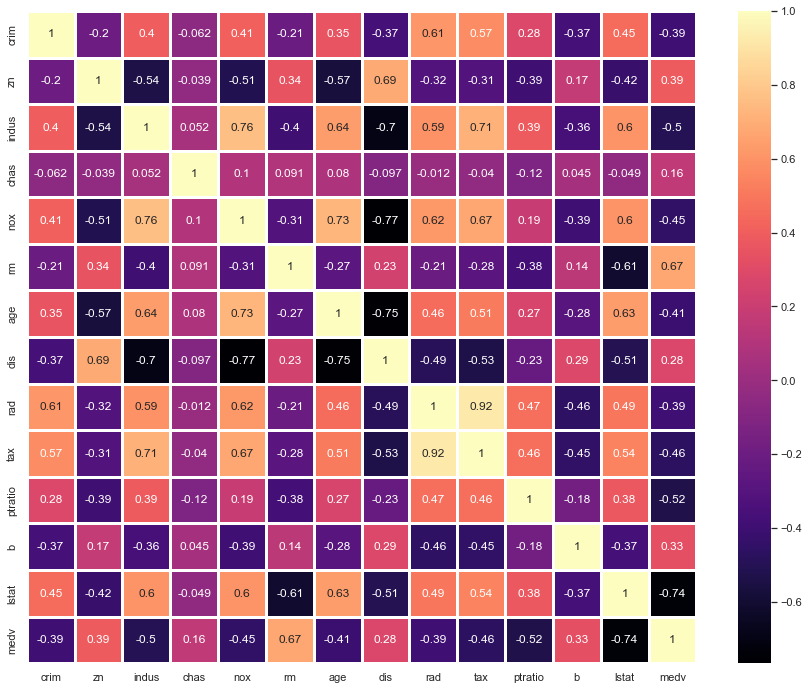

In [7]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(15, 12))
_ = sns.heatmap(corrmat, linecolor = 'white', annot=True, cmap = 'magma', linewidths = 3)

In [8]:
# Correlation with target

corr = df_train.corr()['medv']
corr[np.argsort(abs(corr), axis=0)[::-1]]

medv       1.000000
lstat     -0.741302
rm         0.670963
ptratio   -0.524866
indus     -0.498042
tax       -0.464379
nox       -0.449965
age       -0.413612
rad       -0.393258
crim      -0.392849
zn         0.387510
b          0.329432
dis        0.280202
chas       0.156214
Name: medv, dtype: float64

**Let's say threshold is 0.40:**

In [9]:
cols = ['indus', 'nox', 'rm', 'age', 'tax','ptratio', 'lstat']

model = LinearRegression()
model.fit(X_train[cols], y_train)
y_pred = model.predict(X_test[cols])
print("RMSE (test data) : %.4f" % np.sqrt(np.mean((y_test-y_pred)**2)))

RMSE (test data) : 5.4781


**Let's say threshold is 0.30:**

In [10]:
cols = ['indus', 'nox', 'rm', 'age', 'tax','ptratio', 'lstat','b','zn','crim','rad']

model = LinearRegression()
model.fit(X_train[cols], y_train)
y_pred = model.predict(X_test[cols])
print("RMSE (test data) : %.4f" % np.sqrt(np.mean((y_test-y_pred)**2)))

RMSE (test data) : 5.1759


# 2. Wrapper Methods

## <span style="color:blue">Recursive Feature Elimination (RFE)</span>

In [11]:
len(df.columns)

14

In [12]:
a = 1 
score_list =[]

for n in range(1,len(df.columns)):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=n)
    X_trn_rfe = rfe.fit_transform(X_trn,y_trn)
    X_tst_rfe = rfe.transform(X_tst)
    model.fit(X_trn_rfe,y_trn)
    score = model.score(X_tst_rfe,y_tst)
    score_list.append(score)

model = LinearRegression()
rfe = RFE(model, n_features_to_select=score_list.index(max(score_list))+1)                 
X_rfe = rfe.fit_transform(X_train, y_train)  
model.fit(X_rfe,y_train)              
print(rfe.support_)
print(X_train.columns.to_list())

[ True  True  True  True  True  True False  True  True  True  True  True
  True]
['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']


In [13]:
use_cols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']

model = LinearRegression()
model.fit(X_train[use_cols], y_train)
y_pred = model.predict(X_test[use_cols])
print("RMSE (test data) : %.4f" % np.sqrt(np.mean((y_test-y_pred)**2)))

RMSE (test data) : 4.8326


## <span style="color:blue">RFECV (combination of RFE and Cross-Validation)</span>

In [28]:
selector = RFECV(estimator=model, step=1, cv=5, scoring='neg_root_mean_squared_error')
selector = selector.fit(X_train, y_train)    
print(f'Optimal number of features: {selector.n_features_}')
print()
print(f'Best features:')
print("----------------")
print(f'{X_train.columns[selector.support_].tolist()}')

Optimal number of features: 13

Best features:
----------------
['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']


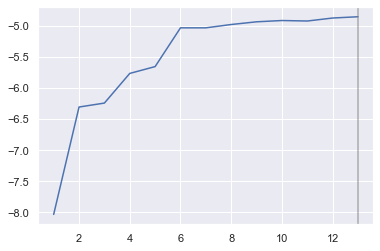

In [24]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_.mean(axis=1))
plt.axvline(x=selector.n_features_, color='gray', alpha=0.6);

# 3. Embedded Methods

## <span style="color:blue">LOFO (Leave-one-feature-out)</span>

In [28]:
dataset = Dataset(df=df_train, target='medv', features=[col for col in df.columns if col != 'medv'])

  0%|          | 0/13 [00:00<?, ?it/s]

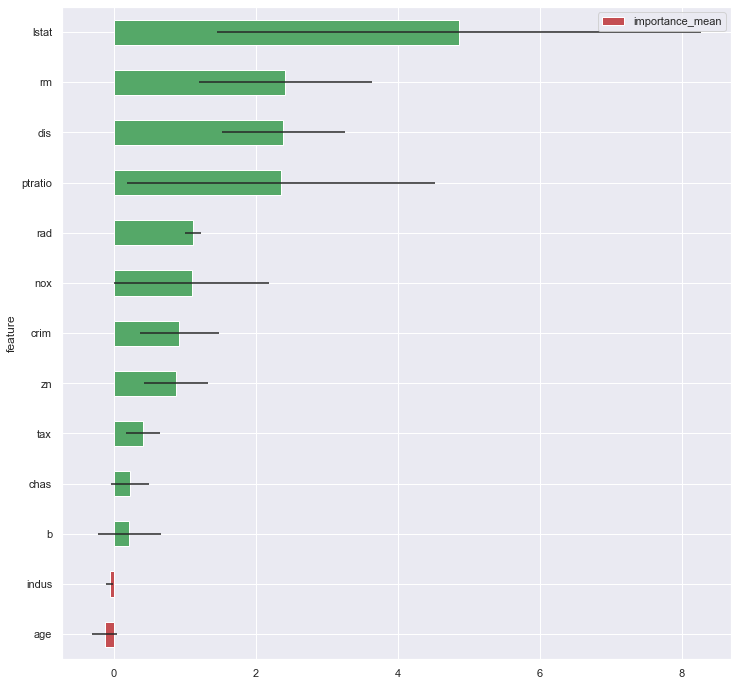

In [29]:
lofo_imp = LOFOImportance(dataset, model=model,scoring='neg_mean_squared_error')
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 12))

LOFO removes **INDUS** and **AGE**.

In [30]:
cols = ['crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'] 

model = LinearRegression()
model.fit(X_train[cols], y_train)
y_pred = model.predict(X_test[cols])
print("RMSE (test data) : %.4f" % np.sqrt(np.mean((y_test-y_pred)**2)))

RMSE (test data) : 4.8335
